# Time series analysis

https://www.youtube.com/watch?v=nT6UsVgJ0xw

In [41]:
import pathlib
import pandas as pd
import numpy as np

## Get data

In [5]:
data_file_name =  pathlib.Path('..') / '..' / 'download_data_dir' / 'household_power_consumption.txt'

In [6]:
data_file_name.exists()

True

In [9]:
dataset = pd.read_csv(data_file_name, sep=';', header=0, low_memory=False,
                   infer_datetime_format=True, parse_dates={'datetime':[0,1]},
                   index_col=['datetime'])

In [11]:
# summarize
dataset.shape

(2075259, 7)

In [13]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [43]:
cols = ['Global_intensity']
power = dataset[cols].rename(columns={
    'Global_intensity': 'consumption'
}).replace('?', np.nan).astype({
    'consumption': 'double'
})
power.index.rename('ts', inplace=True)

## Plot

<AxesSubplot:xlabel='ts'>

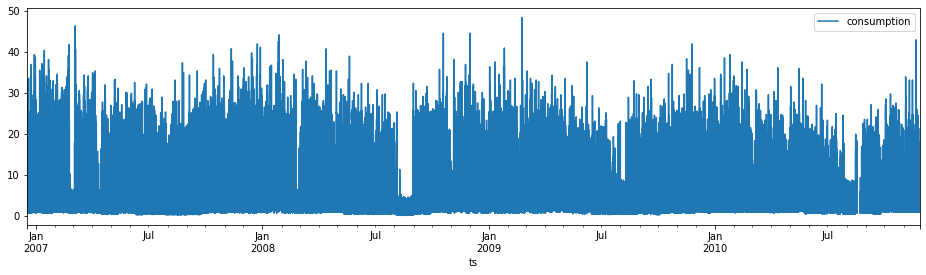

In [47]:
power.plot(figsize=(16, 4))

## Time based manipulations

### Resample

In [49]:
power.resample('Y').mean()

,consumption
ts,
2006-12-31,8.029956
2007-12-31,4.764500
2008-12-31,4.551975
2009-12-31,4.555024
2010-12-31,4.478424


In [52]:
power.resample('3W').mean().head()

,consumption
ts,
2006-12-17,10.664161
2007-01-07,7.280646
2007-01-28,6.732337
2007-02-18,6.652989
2007-03-11,4.740003


In [53]:
power.resample('M').apply(lambda x: np.max(x) - np.min(x)).head()

,consumption
ts,
2006-12-31,38.6
2007-01-31,39.6
2007-02-28,41.0
2007-03-31,45.6
2007-04-30,35.0


In [54]:
power_daily = power.resample('D').sum()
power_daily.head()

,consumption
ts,
2006-12-16,5180.8
2006-12-17,14398.6
2006-12-18,9247.2
2006-12-19,7094.0
2006-12-20,9313.0


Create a time based feature

In [60]:
power_daily.assign(weekofyear=lambda df: df.index.isocalendar().week).head()

,consumption,weekofyear
ts,,
2006-12-16,5180.8,50
2006-12-17,14398.6,50
2006-12-18,9247.2,51
2006-12-19,7094.0,51
2006-12-20,9313.0,51


Shifting

In [64]:
power_daily.assign(
    consumption_yesterday=lambda df: df.consumption.shift(1)
).assign(
    consumption_increase=lambda df: df.consumption - df.consumption_yesterday
).head()

,consumption,consumption_yesterday,consumption_increase
ts,,,
2006-12-16,5180.8,NaN,NaN
2006-12-17,14398.6,5180.8,9217.8
2006-12-18,9247.2,14398.6,-5151.4
2006-12-19,7094.0,9247.2,-2153.2
2006-12-20,9313.0,7094.0,2219.0


### Rolling and smoothing

<AxesSubplot:xlabel='ts'>

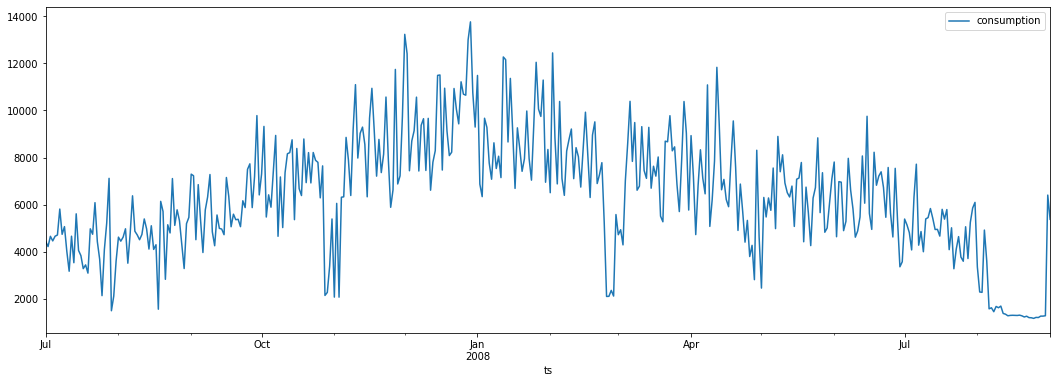

In [80]:
power_daily2008 = power_daily['2007-07-01':'2008-09-01']
power_daily2008.plot(figsize=(18, 6))

#### Rolling average smoothing

<AxesSubplot:xlabel='ts'>

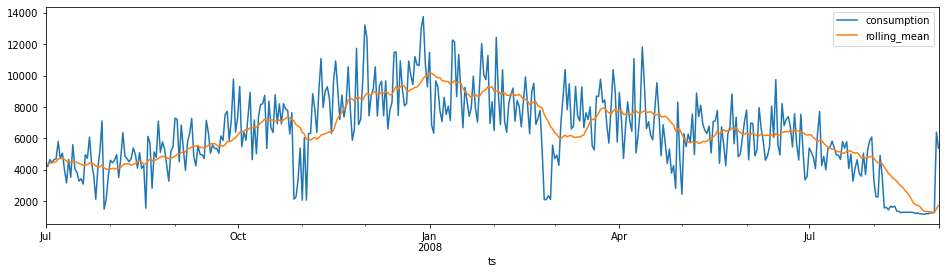

In [81]:
power_daily2008.assign(
    rolling_mean=lambda df: df.consumption.rolling('20D').mean()
).plot(figsize=(16, 4))

#### Centering

<AxesSubplot:xlabel='ts'>

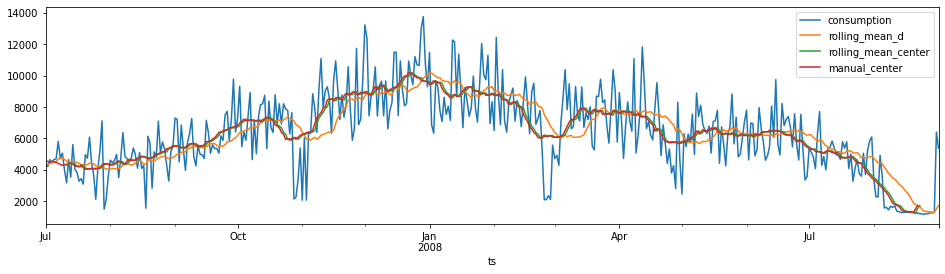

In [76]:
power_daily2008.assign(
    rolling_mean_d=lambda df: df.consumption.rolling('20D').mean(),
    rolling_mean_center=lambda df: df.consumption.rolling(20, center=True).mean(),
    manual_center=lambda df: df.rolling_mean_d.shift(-10)
).plot(figsize=(16, 4))

#### Exponential smoothing

<AxesSubplot:xlabel='ts'>

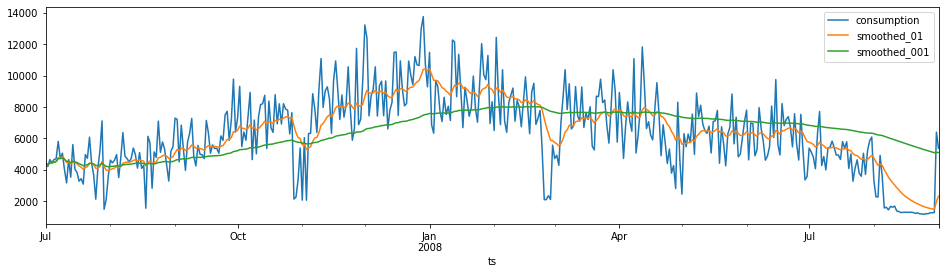

In [85]:
power_daily2008.assign(
    smoothed_01=lambda df: df.consumption.ewm(alpha=0.1).mean(),
    smoothed_001=lambda df: df.consumption.ewm(alpha=0.01).mean(),
).plot(figsize=(16, 4))